# Facial Expression dataset

In [1]:
import torch
from torch import nn, optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Cofusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix
    Normalization can be applied by setting normalized to True
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix with no normalization")

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tickmarks = np.arange(len(classes))
    plt.xticks(tickmarks, classes, rotation=45)
    plt.yticks(tickmarks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i,j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [3]:
from sklearn.metrics import confusion_matrix

### Download the dataset

In [4]:
!wget https://archive.org/download/fer2013_202311/fer2013.csv

--2025-04-25 16:18:43--  https://archive.org/download/fer2013_202311/fer2013.csv
Resolving archive.org (archive.org)... 207.241.224.2
Connecting to archive.org (archive.org)|207.241.224.2|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ia800507.us.archive.org/35/items/fer2013_202311/fer2013.csv [following]
--2025-04-25 16:18:43--  https://ia800507.us.archive.org/35/items/fer2013_202311/fer2013.csv
Resolving ia800507.us.archive.org (ia800507.us.archive.org)... 207.241.230.57
Connecting to ia800507.us.archive.org (ia800507.us.archive.org)|207.241.230.57|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 301072766 (287M) [text/csv]
Saving to: ‘fer2013.csv’

fer2013.csv         100%[===================>] 287.12M  11.8MB/s    in 22s     

2025-04-25 16:19:05 (13.3 MB/s) - ‘fer2013.csv’ saved [301072766/301072766]



In [5]:
# Label encoder
classes = np.array(["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"])

# Image size
IM_SHAPE = 48, 48

In [6]:
# Parse the data
df = pd.read_csv('fer2013.csv', delimiter=",")

### Process the data

In [7]:
# Spilt the data based on the usage
train_data = (df[df["Usage"] == "Training"])[["emotion", "pixels"]]
test_data = (df[(df["Usage"] == "PrivateTest") | (df["Usage"] == "PublicTest")])[["emotion", "pixels"]]

In [8]:
# Get the labels
y_train = train_data[["emotion"]].to_numpy().reshape(-1)
y_test = test_data[["emotion"]].to_numpy().reshape(-1)

# Convert the pixels into a matrix format
X_train = np.array([np.fromstring(img, sep=" ") for img in train_data["pixels"]]).reshape(-1, *IM_SHAPE)
X_test = np.array([np.fromstring(img, sep=" ") for img in test_data["pixels"]]).reshape(-1, *IM_SHAPE)

In [9]:
y_train.shape

(28709,)

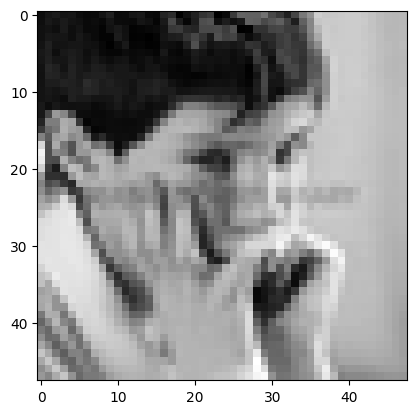

In [10]:
# Sample image
plt.imshow(X_train[3], cmap="grey")
plt.show()

We can see that the number of training example for class 1 is limited. -> weighted loss

In [61]:
_, counts_test = np.unique(y_test, return_counts=True)
counts_test

array([ 958,  111, 1024, 1774, 1247,  831, 1233])

In [11]:
_, counts = np.unique(y_train, return_counts=True)

In [12]:
# Weighted loss (class 1 loss is much more emphasized)
weights = counts / np.sum(counts)
weights = weights.mean() / weights
weights = torch.tensor(weights.astype(np.float32))
weights

tensor([1.0266, 9.4066, 1.0010, 0.5684, 0.8491, 1.2934, 0.8260])

## Build the model

In [55]:
class CNN(nn.Module):
    def __init__(self, num_outs, num_hiddens, drop_out_p1, drop_out_p2):
        super(CNN, self).__init__()

        # Convolution layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2)
        )

        self._flatten_size = 3 * 3 * 512

        # ANN
        self.dense = nn.Sequential(
            nn.Dropout(drop_out_p1),
            nn.Linear(self._flatten_size, num_hiddens),
            nn.ReLU(),
            nn.Dropout(drop_out_p2),
            nn.Linear(num_hiddens, num_outs),
        )

    def forward(self, X):
        out = self.conv1(X)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = out.reshape(out.size(0), -1)  # Flatten the output
        out = self.dense(out)
        return out

In [15]:
def configure(model: nn.Module, device: torch.device, lr: float, optim_method: str, weights: torch.Tensor):
    model.to(device)
    weights = weights.to(device)
    criterion = nn.CrossEntropyLoss(weight=weights)
    if optim_method == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr)
    return criterion, optimizer

In [16]:
def batch_gd(model: nn.Module, criterion: nn.Module, optimizer: optim.Optimizer, device: torch.device,
                train_loader: DataLoader, test_loader: DataLoader, num_epochs: int, record=False):
    assert 0 <= num_epochs

    # Record the loss over time
    loss_history = np.zeros(num_epochs)
    test_history = np.zeros(num_epochs)

    for epoch in range(num_epochs):
        # Train mode
        model.train()

        # Loss over the same epoch
        loss_epoch = []
        for inputs, targets in train_loader:
            # Zero the gradient
            optimizer.zero_grad()

            # Move data to device
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outs = model(inputs)
            loss = criterion(outs, targets)

            # Record the train loss
            loss_epoch.append(loss.item())

            # Backward pass
            loss.backward()
            optimizer.step()

        # Average loss after 1 epoch
        loss_history[epoch] = np.mean(loss_epoch)

        # Eval mode
        model.eval()
        test_epoch = []
        for inputs, targets in test_loader:
            # Zero the gradient
            optimizer.zero_grad()

            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outs = model(inputs)
            test_loss = criterion(outs, targets)

            # Record test loss
            test_epoch.append(test_loss.item())

        # Average loss
        test_history[epoch] = np.mean(test_epoch)

    if record:
        print(f"Epoch {epoch}/{num_epochs}: Train loss={loss_history[epoch]}; Test loss={test_history[epoch]}")

    return loss_history, test_history

## Train the model

In [17]:
from PIL import Image

In [18]:
class EmotionDataset(Dataset):
    """
    Custom Dataset for data augmentation
    """
    def __init__(self, imgs, labels, transform=None):
        super().__init__()
        self.imgs = imgs
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        image = Image.fromarray(self.imgs[index])
        label = torch.tensor(self.labels[index])

        if self.transform:
            image = self.transform(image)

        return image, label

In [19]:
# Transform method for data augmentation
transform = transforms.Compose([
    transforms.RandomAffine(0, (0.1, 0.1)),
    transforms.RandomVerticalFlip(0.25),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

In [20]:
# Wrapper for the dataset
train_dataset = EmotionDataset(X_train, y_train, transform)
test_dataset = EmotionDataset(X_test, y_test, transforms.ToTensor())

# Data loaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False)

In [52]:
# Hyperparameters
lr = 0.05
optim_method = "SGD"
num_epochs = 200
num_hiddens = 4096
drop_out1 = 0.6
drop_out2 = 0.3

In [56]:
# Initiate the model and configure
model = CNN(7, num_hiddens, drop_out1, drop_out2)
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
criterion, optimizer = configure(model, device, lr, optim_method, weights)

In [25]:
from time import perf_counter

In [57]:
# Train the model
start = perf_counter()
loss_his, test_his = batch_gd(model, criterion, optimizer, device, train_loader, test_loader, num_epochs)
end = perf_counter()
f'Time needed: {(end - start) / 60}m{(end - start)//60}s'

'Time needed: 56.08271511701666m56.0s'

## Evaluate the model

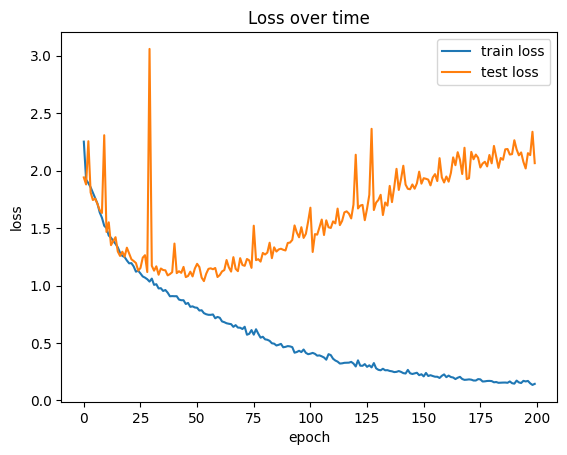

In [58]:
# Plot the loss over time
plt.title("Loss over time")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(loss_his, label="train loss")
plt.plot(test_his, label="test loss")
plt.legend()
plt.show()

In [28]:
def compute_accuracy(model: nn.Module, device, data_loader: DataLoader):
    model.eval()
    n_correct, n_total = 0, 0
    for inputs, targets in data_loader:
        # Move data to device
        inputs, targets = inputs.to(device), targets.to(device)

        outs = model(inputs)
        _, preds = torch.max(outs, 1)

        # compute the accuracy
        n_total += targets.shape[0]
        n_correct += torch.sum((preds == targets)).item()

    return n_correct / n_total

In [59]:
# Compute the accuracies
train_acc = compute_accuracy(model, device, train_loader)
test_acc = compute_accuracy(model, device, test_loader)
f"Train accuracy: {train_acc}; Test accuracy: {test_acc}."

'Train accuracy: 0.9504336619178655; Test accuracy: 0.6749791028141544.'

### Plot the confusion matrix

Confusion matrix with no normalization
[[ 553   19  102   42  124   32   86]
 [  12   84    1    1    9    2    2]
 [ 111    8  501   35  198   85   86]
 [  35    1   36 1530   51   33   88]
 [ 118    5  136   65  693   23  207]
 [  18    0   40   28   17  703   25]
 [  80    2   73  101  177   19  781]]


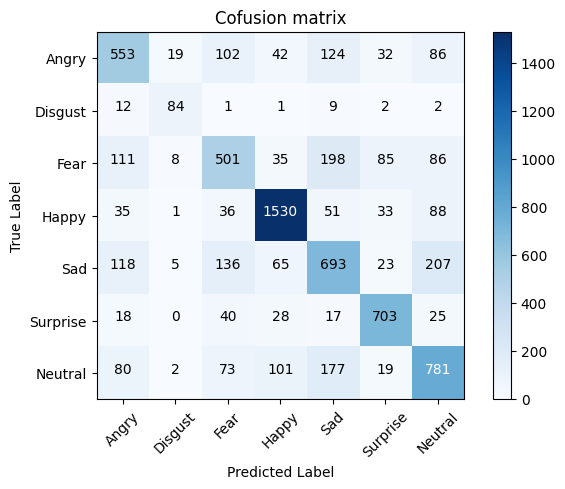

In [62]:
p_test = np.array([])

for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)

    outs = model(inputs)
    _, preds = torch.max(outs, 1)

    p_test = np.concatenate((p_test, preds.cpu().numpy()))

cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, classes)

### Some misidentified data

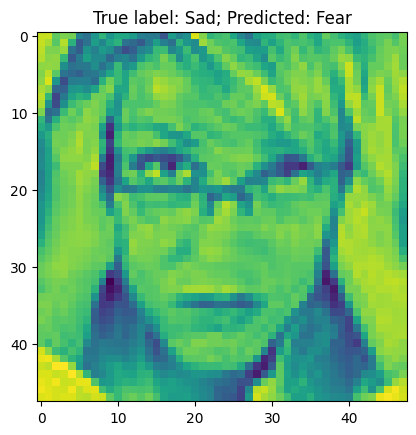

In [64]:
y_test = np.array(y_test).astype(np.int8)
p_test = p_test.astype(np.int8)
misidentified = np.where(p_test != y_test)[0]
sample_idx = np.random.choice(misidentified)
plt.title(f"True label: {classes[y_test[sample_idx]]}; Predicted: {classes[p_test[sample_idx]]}")
plt.imshow(X_test[sample_idx])
plt.show()

In [65]:
from torchsummary import summary

In [66]:
summary(model, (1, 48, 48))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 48]             320
              ReLU-2           [-1, 32, 48, 48]               0
       BatchNorm2d-3           [-1, 32, 48, 48]              64
            Conv2d-4           [-1, 32, 48, 48]           9,248
              ReLU-5           [-1, 32, 48, 48]               0
       BatchNorm2d-6           [-1, 32, 48, 48]              64
         MaxPool2d-7           [-1, 32, 24, 24]               0
            Conv2d-8           [-1, 64, 24, 24]          18,496
              ReLU-9           [-1, 64, 24, 24]               0
      BatchNorm2d-10           [-1, 64, 24, 24]             128
           Conv2d-11           [-1, 64, 24, 24]          36,928
             ReLU-12           [-1, 64, 24, 24]               0
      BatchNorm2d-13           [-1, 64, 24, 24]             128
           Conv2d-14          [-1, 128,